In [ ]:
#needed dependencies for io in Drive
!pip install -U -q PyDrive
!pip install h5py
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/CST/BabyLM-Idea/Strict-2025/"

Mounted at /content/drive
all_models_detailed_results.json	    StrictFig-MainBody.ipynb
all_models_last_checkpoint_detailed.json    StrictFigs.ipynb
all_models_last_checkpoint_simplified.json  StrictFigs-Revised.ipynb
all_models_simplified_results.json


/tmp/ipython-input-2266248535.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20", len(unique_seq_lens))
/tmp/ipython-input-2266248535.py:95: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


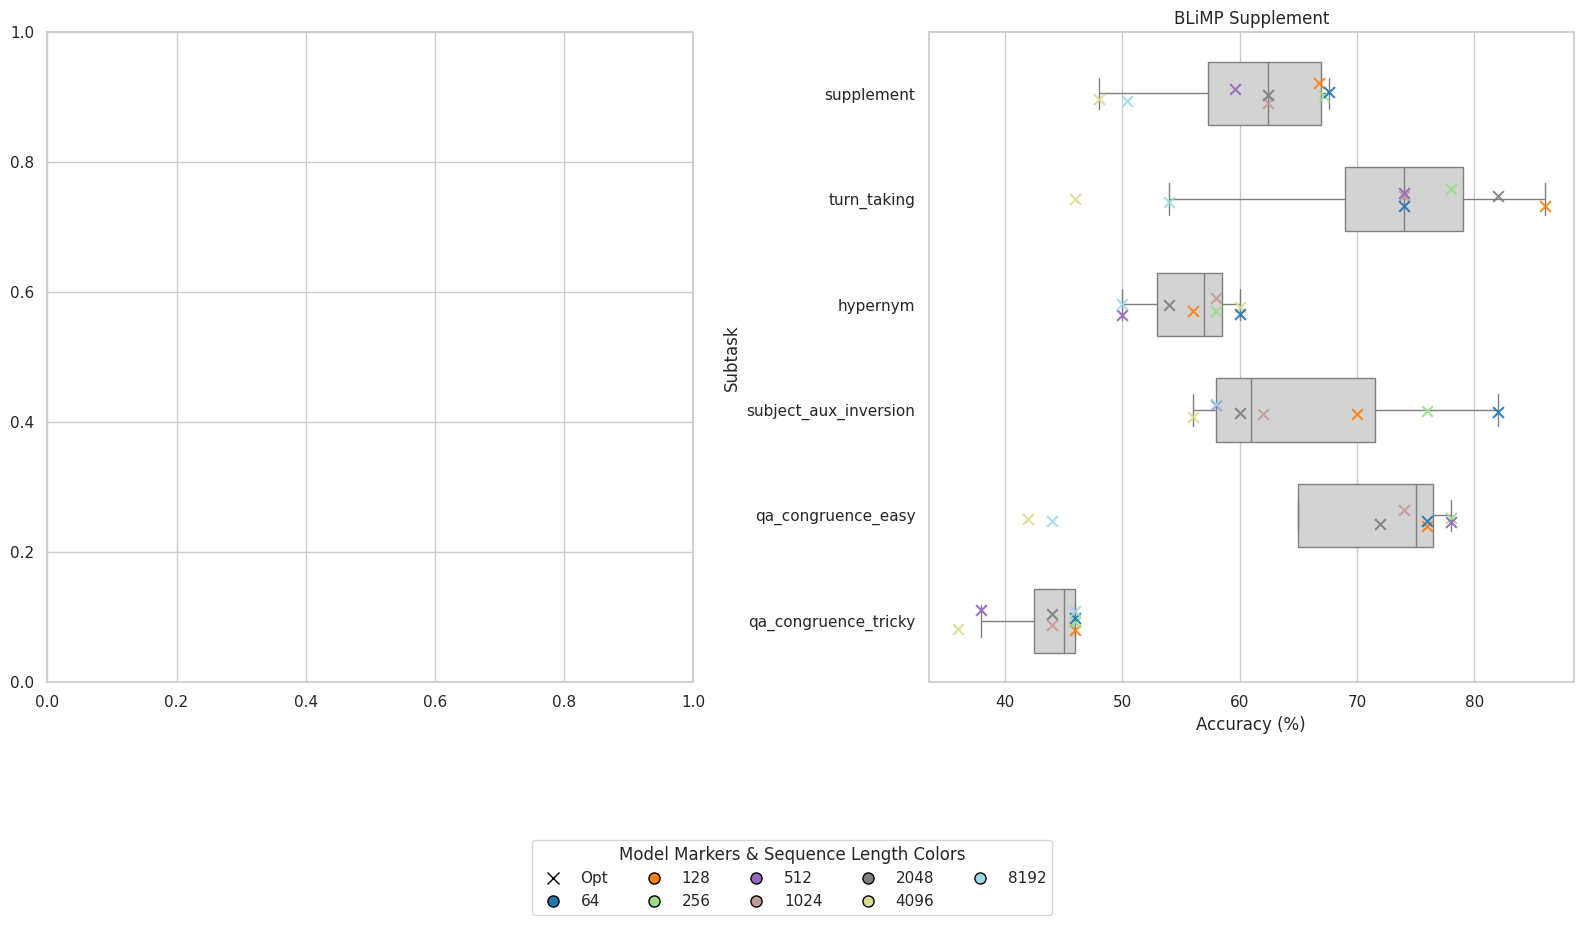

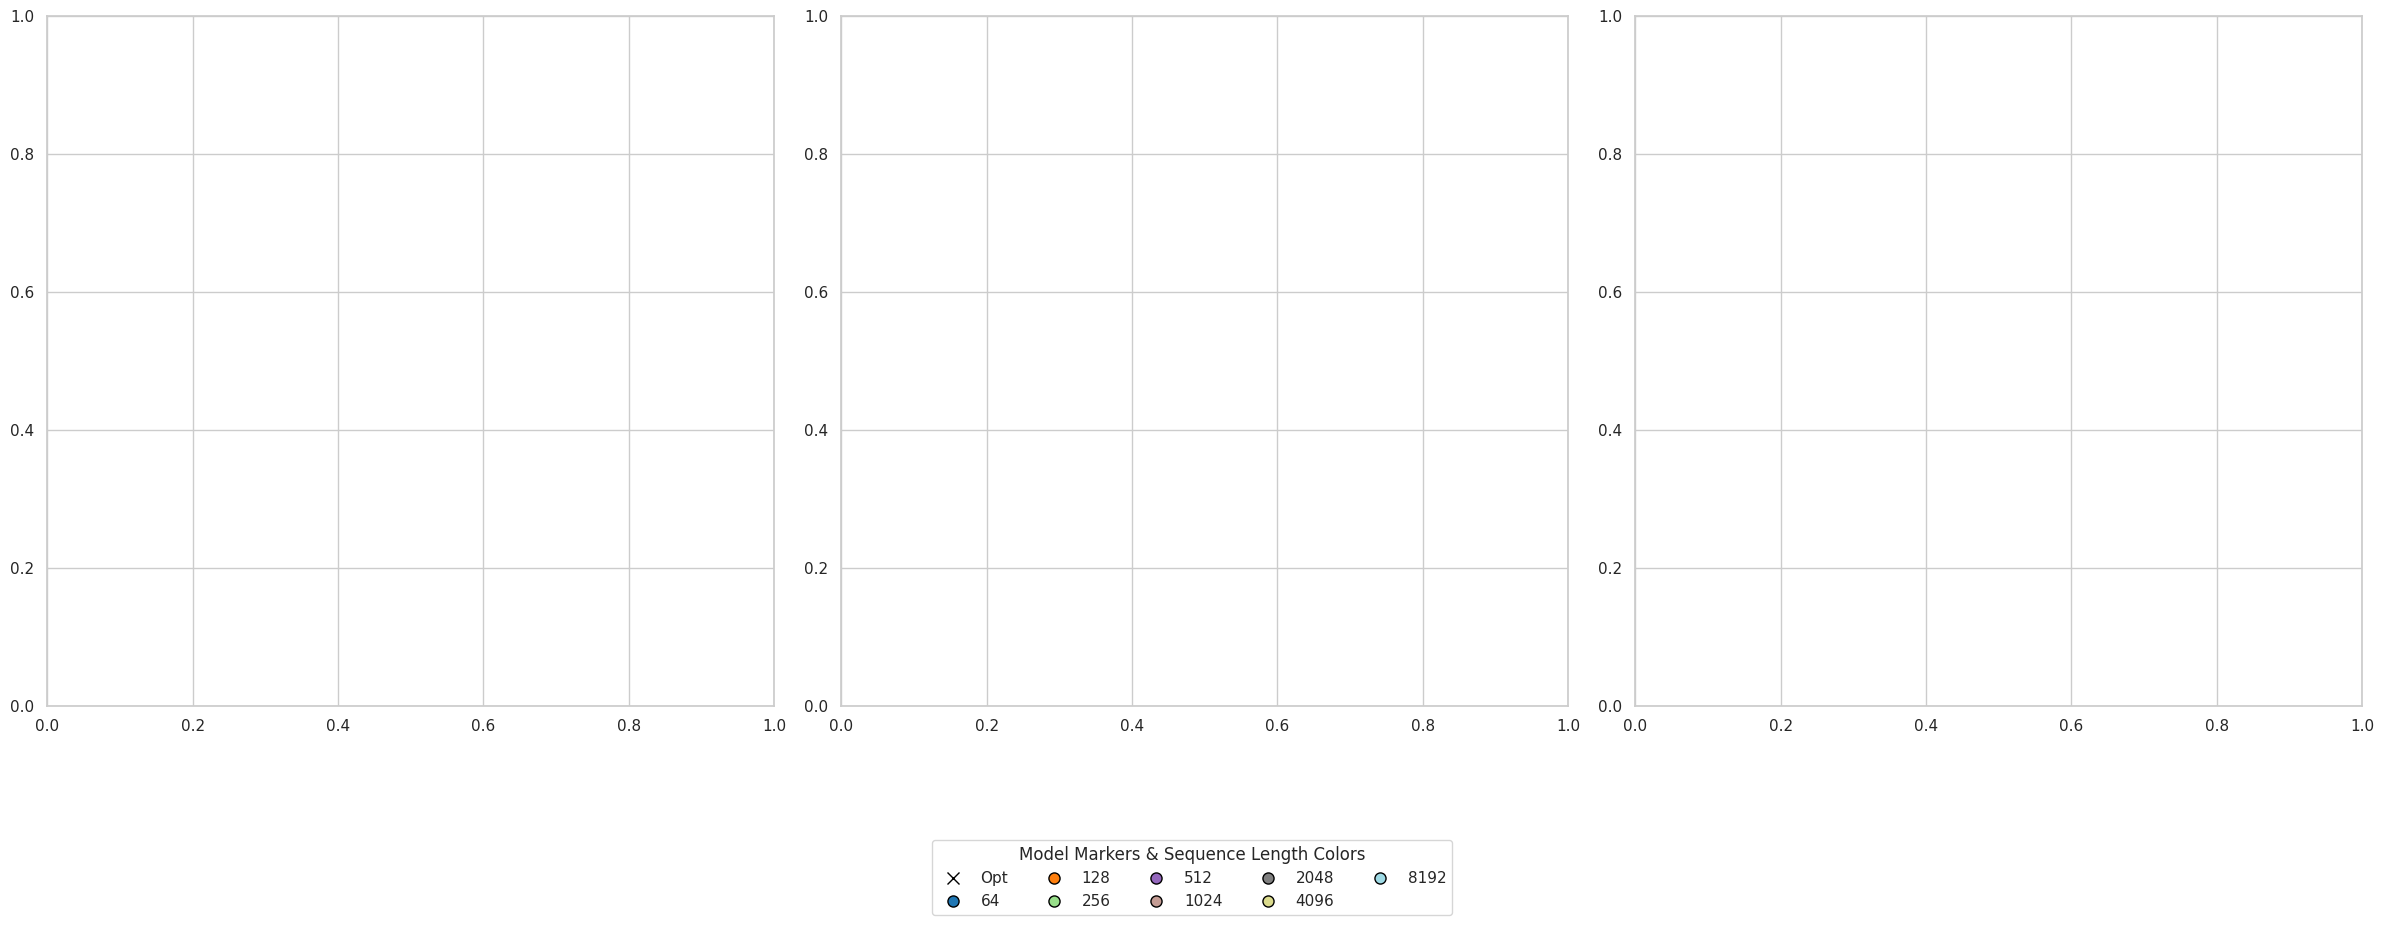

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

# Labeling hook – you can expand this
def label_with_spacing(df_sub_sorted, y_pos, side="left", spacing=1.0):
    pass

pretty_task_names = {
    "zero_shot_causal_blimp": "BLiMP",
    "zero_shot_causal_blimp_supplement_fast": "BLiMP Supplement",
    "zero_shot_causal_entity_tracking": "Entity Tracking",
    "zero_shot_causal_ewok": "EWoK",
    "zero_shot_causal_wug": "WUG"
}

# --- Load JSON ---
with open('/content/drive/MyDrive/CST/BabyLM-Idea/Strict-2025/all_models_detailed_results.json', 'r') as f:
    data = json.load(f)

# --- Collect rows ---
rows = []
for model_name, checkpoints in data.items():
    if model_name.lower().startswith("mamba"):
        continue  # skip Mamba models
    parts = model_name.split("-")
    model_type = parts[0].capitalize()
    seq_len = next((int(p) for p in parts if p.isdigit()), None)
    if seq_len is None:
        continue
    if "1000M" not in checkpoints:
        continue

    ckpt_data = checkpoints["1000M"]
    for task_name, task_data in ckpt_data.items():
        # Only include tasks we care about
        if task_name not in pretty_task_names:
            continue
        if not isinstance(task_data, dict):
            continue
        for subtask, score in task_data.items():
            if subtask == "average_accuracy":
                continue
            rows.append({
                "model": model_type,
                "seq_len": seq_len,
                "task": task_name,
                "subtask": subtask,
                "score": score
            })

df = pd.DataFrame(rows)

sns.set(style="whitegrid")

# Color/marker settings
unique_seq_lens = sorted(df["seq_len"].unique())
cmap = get_cmap("tab20", len(unique_seq_lens))
seq_len_to_color = {seq: cmap(i) for i, seq in enumerate(unique_seq_lens)}

model_to_marker = {
    "Opt": "x"
}

# ------------------
# FIGURE 1: BLiMP and BLiMP Supplement
# ------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=False)

figure1_tasks = ["zero_shot_causal_blimp", "zero_shot_causal_blimp_supplement_fast"]
for ax, task_name in zip(axes, figure1_tasks):
    df_task = df[df["task"] == task_name]
    if df_task.empty:
        continue

    sns.boxplot(
        data=df_task,
        y="subtask",
        x="score",
        whis=1.5,
        width=0.6,
        fliersize=0,
        color='lightgray',
        orient='h',
        ax=ax
    )

    for _, row in df_task.iterrows():
        y_pos = list(df_task["subtask"].unique()).index(row["subtask"])
        jitter = (0.5 - np.random.rand()) * 0.2
        ax.scatter(
            row["score"],
            y_pos + jitter,
            marker=model_to_marker.get(row["model"], "o"),
            color=seq_len_to_color.get(row["seq_len"], "gray"),
            edgecolor="black",
            s=60,
            alpha=0.9,
            zorder=3
        )

    for subtask in df_task["subtask"].unique():
        df_sub = df_task[df_task["subtask"] == subtask]
        df_sorted = df_sub.sort_values("score")
        y_pos = list(df_task["subtask"].unique()).index(subtask)

        label_with_spacing(df_sorted.head(3), y_pos, side="left", spacing=1.0)
        label_with_spacing(df_sorted.tail(3), y_pos, side="right", spacing=1.0)

    ax.set_title(pretty_task_names[task_name])
    ax.set_xlabel("Accuracy (%)")
    ax.set_ylabel("Subtask")

# Legend for Figure 1
model_handles = [
    Line2D([0], [0], marker=marker, color='w', label=model,
           markerfacecolor='gray', markeredgecolor='black', markersize=8)
    for model, marker in model_to_marker.items()
]
seq_len_handles = [
    Line2D([0], [0], marker='o', color='w', label=str(seq_len),
           markerfacecolor=color, markeredgecolor='black', markersize=8)
    for seq_len, color in seq_len_to_color.items()
]
fig.legend(handles=model_handles + seq_len_handles,
           title="Model Markers & Sequence Length Colors",
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center',
           ncol=5,
           frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("figure1_blimp_and_supplement.png", dpi=300)
plt.show()

# ------------------
# FIGURE 2: EWoK, WUG, Entity Tracking
# ------------------
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=False)

figure2_tasks = ["zero_shot_causal_ewok", "zero_shot_causal_wug", "zero_shot_causal_entity_tracking"]
for ax, task_name in zip(axes, figure2_tasks):
    df_task = df[df["task"] == task_name]
    if df_task.empty:
        continue

    sns.boxplot(
        data=df_task,
        y="subtask",
        x="score",
        whis=1.5,
        width=0.6,
        fliersize=0,
        color='lightgray',
        orient='h',
        ax=ax
    )

    for _, row in df_task.iterrows():
        y_pos = list(df_task["subtask"].unique()).index(row["subtask"])
        jitter = (0.5 - np.random.rand()) * 0.2
        ax.scatter(
            row["score"],
            y_pos + jitter,
            marker=model_to_marker.get(row["model"], "o"),
            color=seq_len_to_color.get(row["seq_len"], "gray"),
            edgecolor="black",
            s=60,
            alpha=0.9,
            zorder=3
        )

    for subtask in df_task["subtask"].unique():
        df_sub = df_task[df_task["subtask"] == subtask]
        df_sorted = df_sub.sort_values("score")
        y_pos = list(df_task["subtask"].unique()).index(subtask)

        label_with_spacing(df_sorted.head(3), y_pos, side="left", spacing=1.0)
        label_with_spacing(df_sorted.tail(3), y_pos, side="right", spacing=1.0)

    ax.set_title(pretty_task_names[task_name])
    ax.set_xlabel("Accuracy (%)")
    ax.set_ylabel("Subtask")

# Legend for Figure 2
fig.legend(handles=model_handles + seq_len_handles,
           title="Model Markers & Sequence Length Colors",
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center',
           ncol=5,
           frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("figure2_ewok_wug_entity_tracking.png", dpi=300)
plt.show()


/tmp/ipython-input-2106284350.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20", len(unique_seq_lens))
/tmp/ipython-input-2106284350.py:149: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2106284350.py:149: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2106284350.py:189: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.05

/tmp/ipython-input-2106284350.py:219: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2106284350.py:219: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2106284350.py:219: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2106284350.py:219: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2

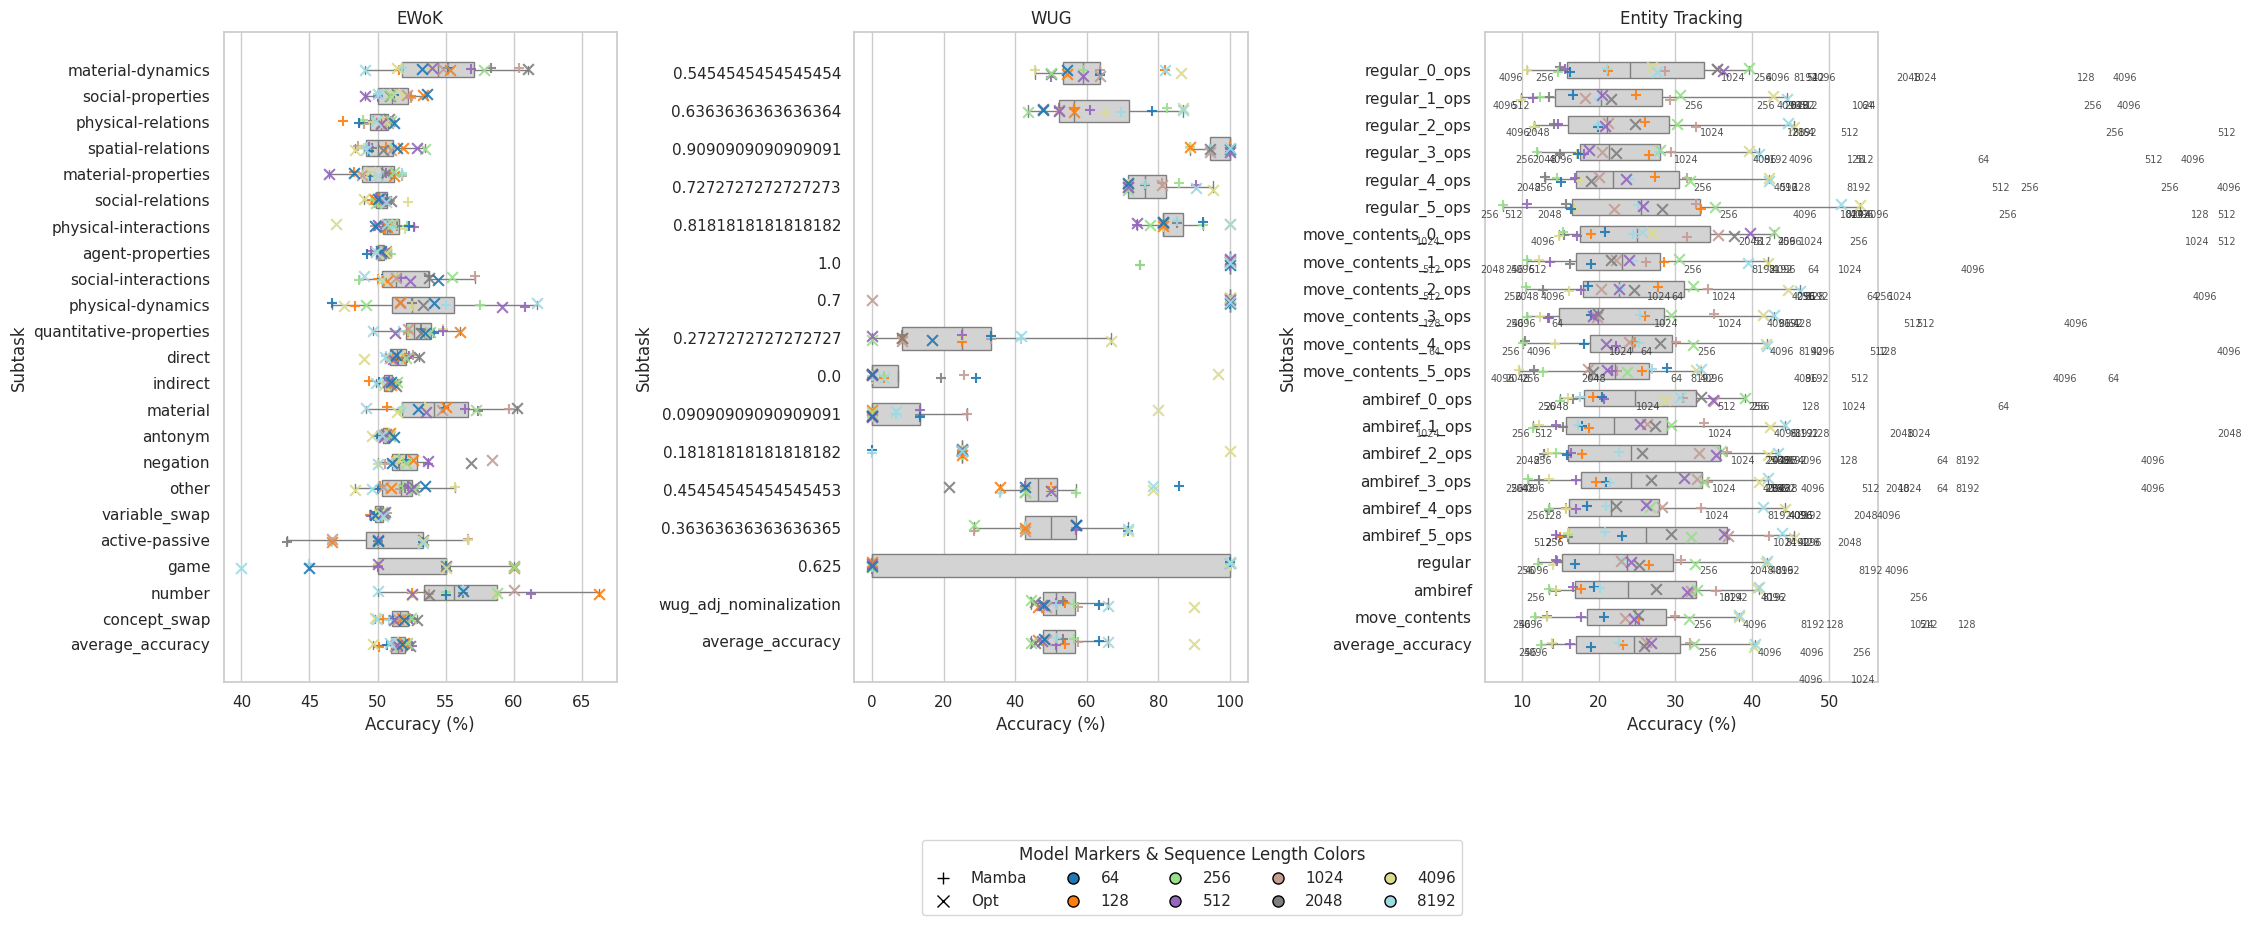

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

# ---------- Helpers ----------

def parse_model_name(name):
    parts = name.split("-")
    model_type = parts[0] if parts[0] in {"mamba", "opt"} else None
    seq_len = None
    warmup = "-"
    for part in parts[1:]:
        if part.isdigit():
            seq_len = int(part)
        elif "warmup" in part:
            warmup = "+"
    return model_type, warmup, seq_len

def label_with_spacing(df_sorted, y_pos, side="left", spacing=1.0):
    labeled_scores = []
    for _, row in df_sorted.iterrows():
        # Skip labels that are too close to previously labeled scores
        too_close = any(abs(row["score"] - s) < spacing for s in labeled_scores)
        if too_close:
            continue
        offset = -0.5 if side == "left" else 0.5
        ha = "right" if side == "left" else "left"
        plt.text(
            row["score"] + offset,
            y_pos + 0.3,
            str(row['seq_len']),
            fontsize=7,
            ha=ha,
            va='center',
            alpha=0.8,
            zorder=5
        )
        labeled_scores.append(row["score"])

pretty_task_names = {
    "zero_shot_causal_blimp": "BLiMP",
    "zero_shot_causal_blimp_supplement_fast": "BLiMP Supplement",
    "zero_shot_causal_entity_tracking": "Entity Tracking",
    "zero_shot_causal_ewok": "EWoK",
    "zero_shot_causal_wug": "WUG"
}

# ---------- Load Data ----------

with open('/content/drive/MyDrive/CST/BabyLM-Idea/Strict-2025/all_models_last_checkpoint_detailed.json', 'r') as f:
    data = json.load(f)

# ---------- Parse Tasks ----------

rows = []

# BLiMP subtasks from your original snippet:
task_subtasks = {
    "zero_shot_causal_blimp": [
        "argument_structure", "anaphor_agreement", "quantifiers",
        "binding", "island_effects", "subject_verb_agreement",
        "filler_gap_dependency", "control_raising",
        "determiner_noun_agreement", "npi_licensing", "s-selection",
        "ellipsis", "irregular_forms"
    ],
    "zero_shot_causal_blimp_supplement_fast": None,
    "zero_shot_causal_wug": None,
    "zero_shot_causal_ewok": None,
    "zero_shot_causal_entity_tracking": None
}

for ckpt_name, ckpt_data in data.items():
    model_type, warmup, seq_len = parse_model_name(ckpt_name)
    if model_type is None or seq_len is None:
        continue

    for task, subtasks in task_subtasks.items():
        task_data = ckpt_data.get(task)
        if task_data is None:
            continue

        # BLiMP main task subtasks are under "best_temperature_report.txt"
        if task == "zero_shot_causal_blimp":
            subtask_data = task_data.get("best_temperature_report.txt", {})
        else:
            subtask_data = task_data

        if subtasks is None:
            subtask_iter = subtask_data.items()
        else:
            subtask_iter = ((s, subtask_data.get(s)) for s in subtasks)

        for subtask, score in subtask_iter:
            if isinstance(score, (int, float)):
                rows.append({
                    "model": model_type.capitalize(),
                    "warmup": warmup,
                    "seq_len": seq_len,
                    "task": task,
                    "subtask": subtask,
                    "score": score
                })

df = pd.DataFrame(rows)

# ---------- Plotting ----------

sns.set(style="whitegrid")

unique_seq_lens = sorted(df["seq_len"].unique())
cmap = get_cmap("tab20", len(unique_seq_lens))
seq_len_to_color = {seq: cmap(i) for i, seq in enumerate(unique_seq_lens)}

model_to_marker = {
    "Mamba": "+",
    "Opt": "x"
}

# --------
# FIGURE 1: BLiMP and BLiMP Supplement
# --------
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=False)

figure1_tasks = ["zero_shot_causal_blimp", "zero_shot_causal_blimp_supplement_fast"]
for ax, task_name in zip(axes, figure1_tasks):
    df_task = df[df["task"] == task_name]
    if df_task.empty:
        continue

    sns.boxplot(
        data=df_task,
        y="subtask",
        x="score",
        whis=1.5,
        width=0.6,
        fliersize=0,
        color='lightgray',
        orient='h',
        ax=ax
    )

    for _, row in df_task.iterrows():
        y_pos = list(df_task["subtask"].unique()).index(row["subtask"])
        jitter = (0.5 - np.random.rand()) * 0.2
        ax.scatter(
            row["score"],
            y_pos + jitter,
            marker=model_to_marker.get(row["model"], "o"),
            color=seq_len_to_color.get(row["seq_len"], "gray"),
            edgecolor="black",
            s=60,
            alpha=0.9,
            zorder=3
        )

    for subtask in df_task["subtask"].unique():
        df_sub = df_task[df_task["subtask"] == subtask]
        df_sorted = df_sub.sort_values("score")
        y_pos = list(df_task["subtask"].unique()).index(subtask)

        label_with_spacing(df_sorted.head(3), y_pos, side="left", spacing=1.0)
        label_with_spacing(df_sorted.tail(3), y_pos, side="right", spacing=1.0)

    ax.set_title(pretty_task_names[task_name])
    ax.set_xlabel("Accuracy (%)")
    ax.set_ylabel("Subtask")

model_handles = [
    Line2D([0], [0], marker=marker, color='w', label=model,
           markerfacecolor='gray', markeredgecolor='black', markersize=8)
    for model, marker in model_to_marker.items()
]
seq_len_handles = [
    Line2D([0], [0], marker='o', color='w', label=str(seq_len),
           markerfacecolor=color, markeredgecolor='black', markersize=8)
    for seq_len, color in seq_len_to_color.items()
]
fig.legend(handles=model_handles + seq_len_handles,
           title="Model Markers & Sequence Length Colors",
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center',
           ncol=5,
           frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("figure1_blimp_and_supplement.png", dpi=300)
plt.show()

# --------
# FIGURE 2: EWoK, WUG, Entity Tracking
# --------
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=False)

figure2_tasks = ["zero_shot_causal_ewok", "zero_shot_causal_wug", "zero_shot_causal_entity_tracking"]
for ax, task_name in zip(axes, figure2_tasks):
    df_task = df[df["task"] == task_name]
    if df_task.empty:
        continue

    sns.boxplot(
        data=df_task,
        y="subtask",
        x="score",
        whis=1.5,
        width=0.6,
        fliersize=0,
        color='lightgray',
        orient='h',
        ax=ax
    )

    for _, row in df_task.iterrows():
        y_pos = list(df_task["subtask"].unique()).index(row["subtask"])
        jitter = (0.5 - np.random.rand()) * 0.2
        ax.scatter(
            row["score"],
            y_pos + jitter,
            marker=model_to_marker.get(row["model"], "o"),
            color=seq_len_to_color.get(row["seq_len"], "gray"),
            edgecolor="black",
            s=60,
            alpha=0.9,
            zorder=3
        )

    for subtask in df_task["subtask"].unique():
        df_sub = df_task[df_task["subtask"] == subtask]
        df_sorted = df_sub.sort_values("score")
        y_pos = list(df_task["subtask"].unique()).index(subtask)

        label_with_spacing(df_sorted.head(3), y_pos, side="left", spacing=1.0)
        label_with_spacing(df_sorted.tail(3), y_pos, side="right", spacing=1.0)

    ax.set_title(pretty_task_names[task_name])
    ax.set_xlabel("Accuracy (%)")
    ax.set_ylabel("Subtask")

fig.legend(handles=model_handles + seq_len_handles,
           title="Model Markers & Sequence Length Colors",
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center',
           ncol=5,
           frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("figure2_ewok_wug_entity_tracking.png", dpi=300)
plt.show()


/tmp/ipython-input-2975310697.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2975310697.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


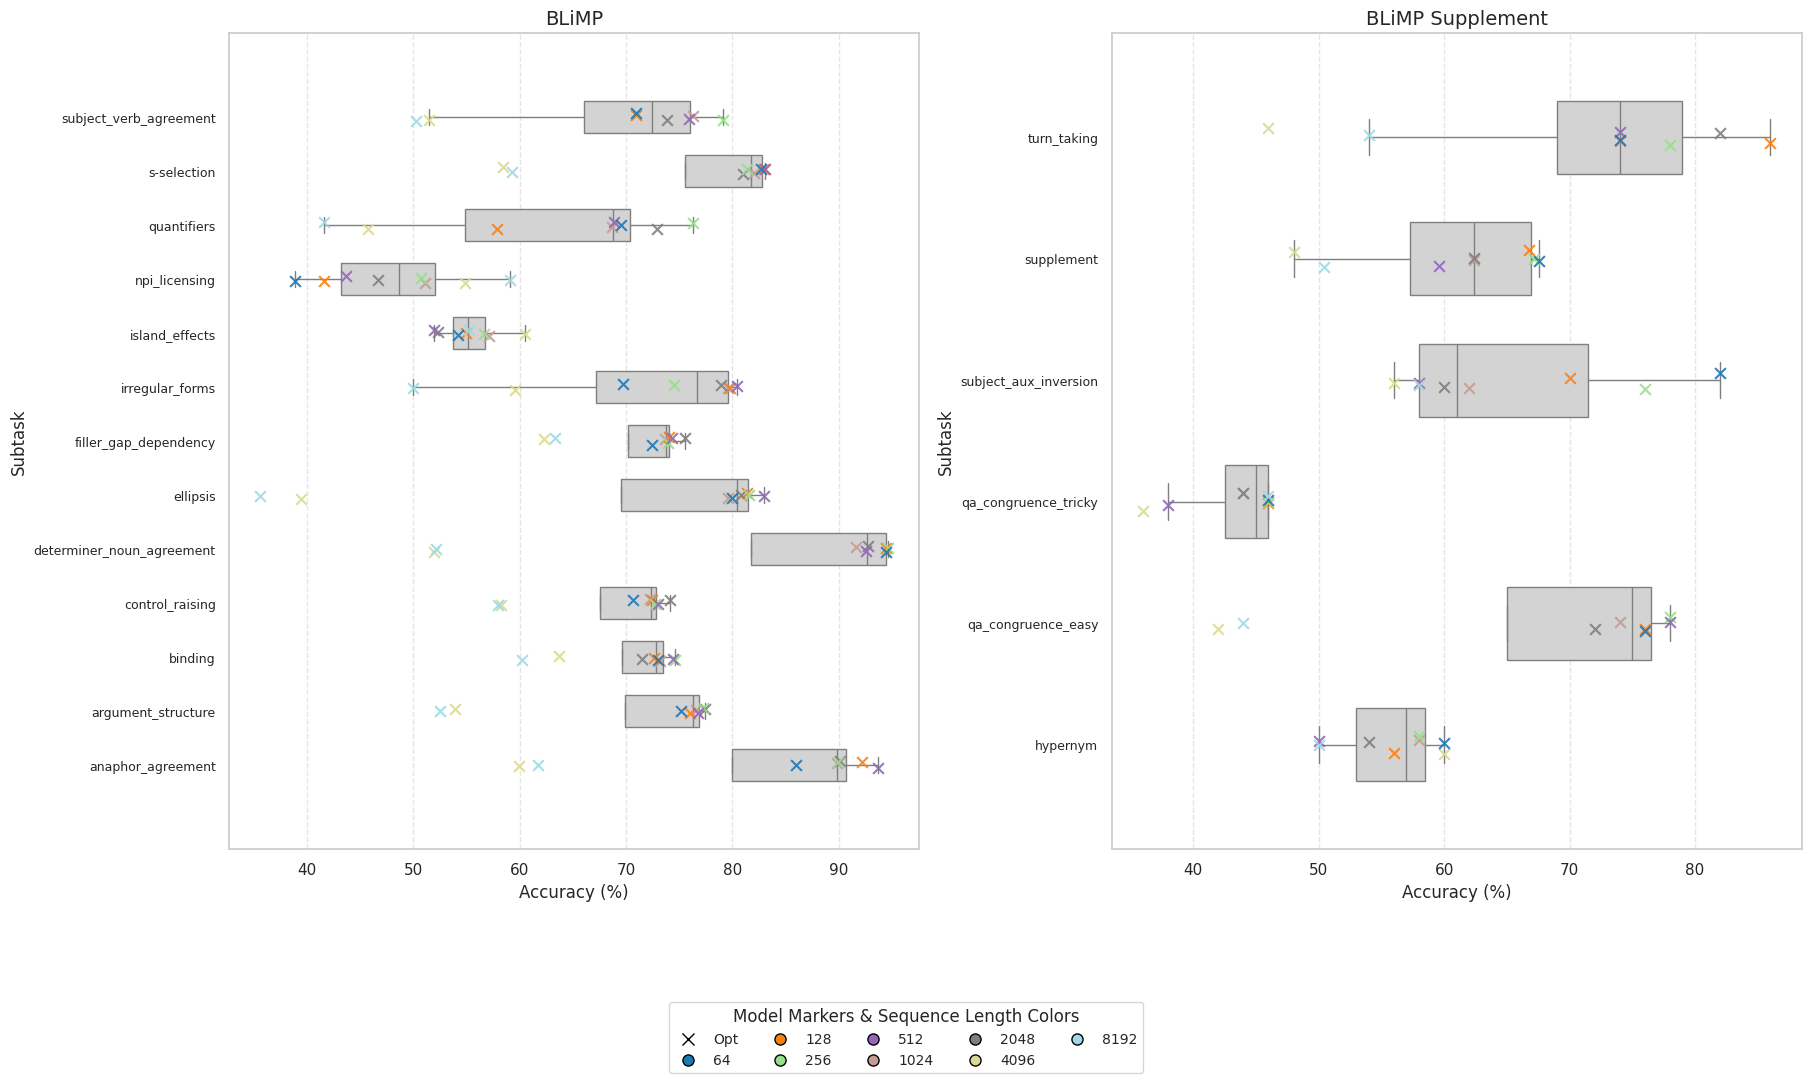

/tmp/ipython-input-2975310697.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2975310697.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-2975310697.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


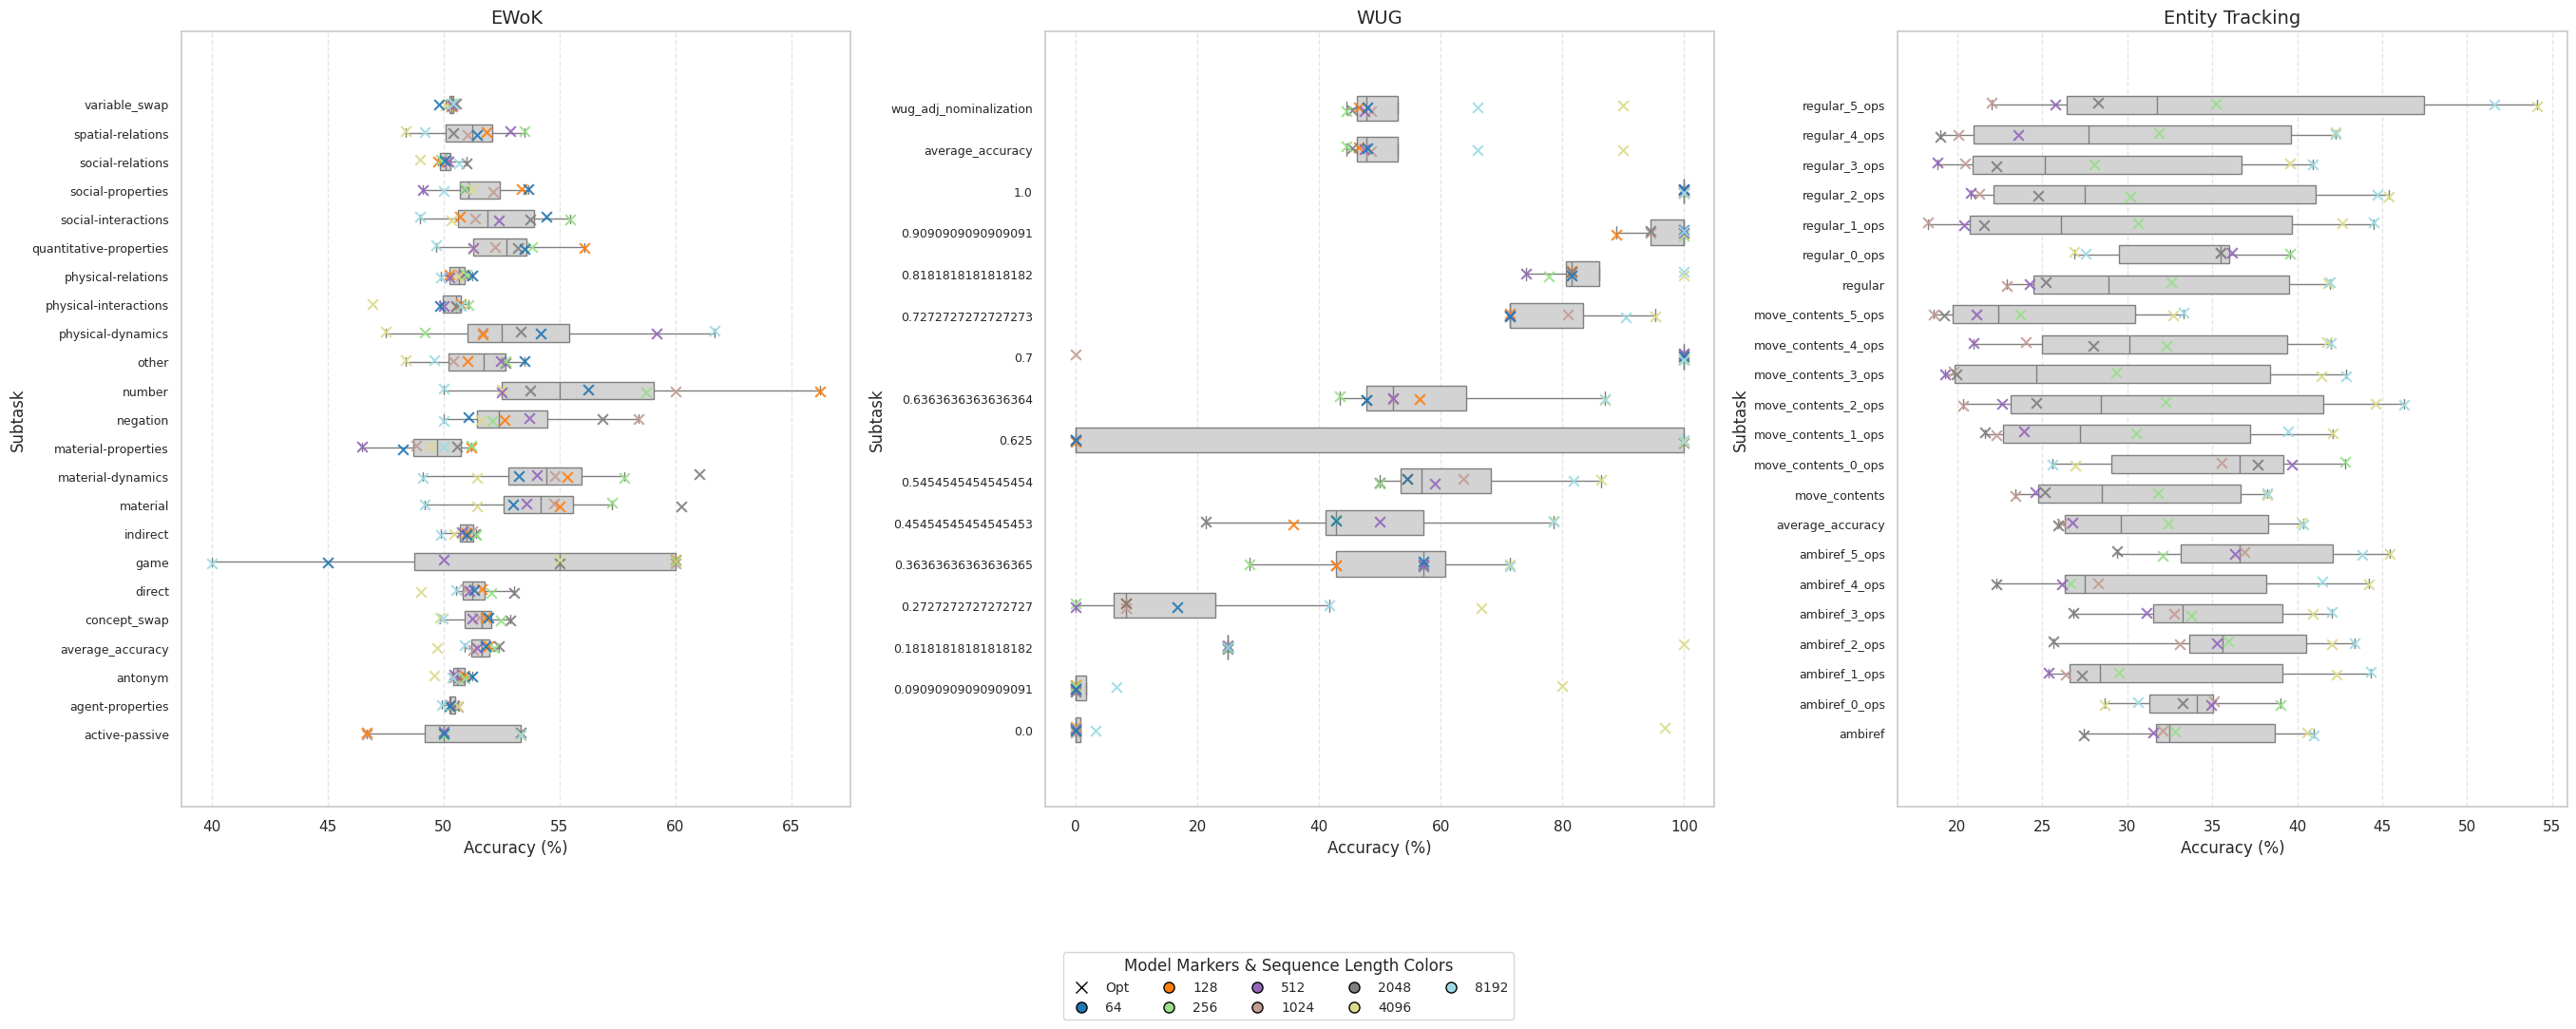

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

def plot_task_panels(df, tasks, axes, pretty_task_names, seq_len_to_color, model_to_marker):
    for ax, task_name in zip(axes, tasks):
        df_task = df[df["task"] == task_name]
        if df_task.empty:
            ax.set_visible(False)
            continue

        subtasks_order = sorted(df_task["subtask"].unique())
        # Boxplot with fixed order, orient horizontal
        sns.boxplot(
            data=df_task,
            y="subtask",
            x="score",
            order=subtasks_order,
            whis=1.5,
            width=0.6,
            fliersize=0,
            color='lightgray',
            orient='h',
            ax=ax
        )

        # Scatter points with jitter around y-position
        for _, row in df_task.iterrows():
            y_pos = subtasks_order.index(row["subtask"])
            jitter = (np.random.rand() - 0.5) * 0.15  # smaller jitter
            ax.scatter(
                row["score"],
                y_pos + jitter,
                marker=model_to_marker.get(row["model"], "o"),
                color=seq_len_to_color.get(row["seq_len"], "gray"),
                edgecolor="black",
                s=60,
                alpha=0.9,
                zorder=3
            )

        ax.set_title(pretty_task_names.get(task_name, task_name), fontsize=14)
        ax.set_xlabel("Accuracy (%)", fontsize=12)
        ax.set_ylabel("Subtask", fontsize=12)
        ax.invert_yaxis()  # to have top subtask at the top

        # Make sure yticks correspond exactly to subtasks with readable font size
        ax.set_yticks(range(len(subtasks_order)))
        ax.set_yticklabels(subtasks_order, fontsize=9)

        # Increase left margin for labels to not cut off text
        ax.margins(y=0.1)
        ax.grid(True, axis='x', linestyle='--', alpha=0.5)

def create_legend(fig, model_to_marker, seq_len_to_color, legend_title, loc='upper center', ncol=5):
    model_handles = [
        Line2D([0], [0], marker=marker, color='w', label=model,
               markerfacecolor='gray', markeredgecolor='black', markersize=8)
        for model, marker in model_to_marker.items()
    ]
    seq_len_handles = [
        Line2D([0], [0], marker='o', color='w', label=str(seq_len),
               markerfacecolor=color, markeredgecolor='black', markersize=8)
        for seq_len, color in seq_len_to_color.items()
    ]
    legend = fig.legend(
        handles=model_handles + seq_len_handles,
        title=legend_title,
        bbox_to_anchor=(0.5, -0.1),
        loc=loc,
        ncol=ncol,
        frameon=True,
        fontsize=10,
        title_fontsize=12
    )
    return legend

# --------
# FIGURE 1: BLiMP and BLiMP Supplement
# --------
fig, axes = plt.subplots(1, 2, figsize=(18, 9), constrained_layout=True)

figure1_tasks = ["zero_shot_causal_blimp", "zero_shot_causal_blimp_supplement_fast"]
plot_task_panels(df, figure1_tasks, axes, pretty_task_names, seq_len_to_color, model_to_marker)
create_legend(fig, model_to_marker, seq_len_to_color, "Model Markers & Sequence Length Colors")

plt.savefig("figure1_blimp_and_supplement.png", dpi=300)
plt.show()


# --------
# FIGURE 2: EWoK, WUG, Entity Tracking
# --------
fig, axes = plt.subplots(1, 3, figsize=(27, 9), constrained_layout=True)

figure2_tasks = ["zero_shot_causal_ewok", "zero_shot_causal_wug", "zero_shot_causal_entity_tracking"]
plot_task_panels(df, figure2_tasks, axes, pretty_task_names, seq_len_to_color, model_to_marker)
create_legend(fig, model_to_marker, seq_len_to_color, "Model Markers & Sequence Length Colors")

plt.savefig("figure2_ewok_wug_entity_tracking.png", dpi=300)
plt.show()


/tmp/ipython-input-3485412668.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-3485412668.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-3485412668.py:88: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2)  # <-- Make space for legend below figure


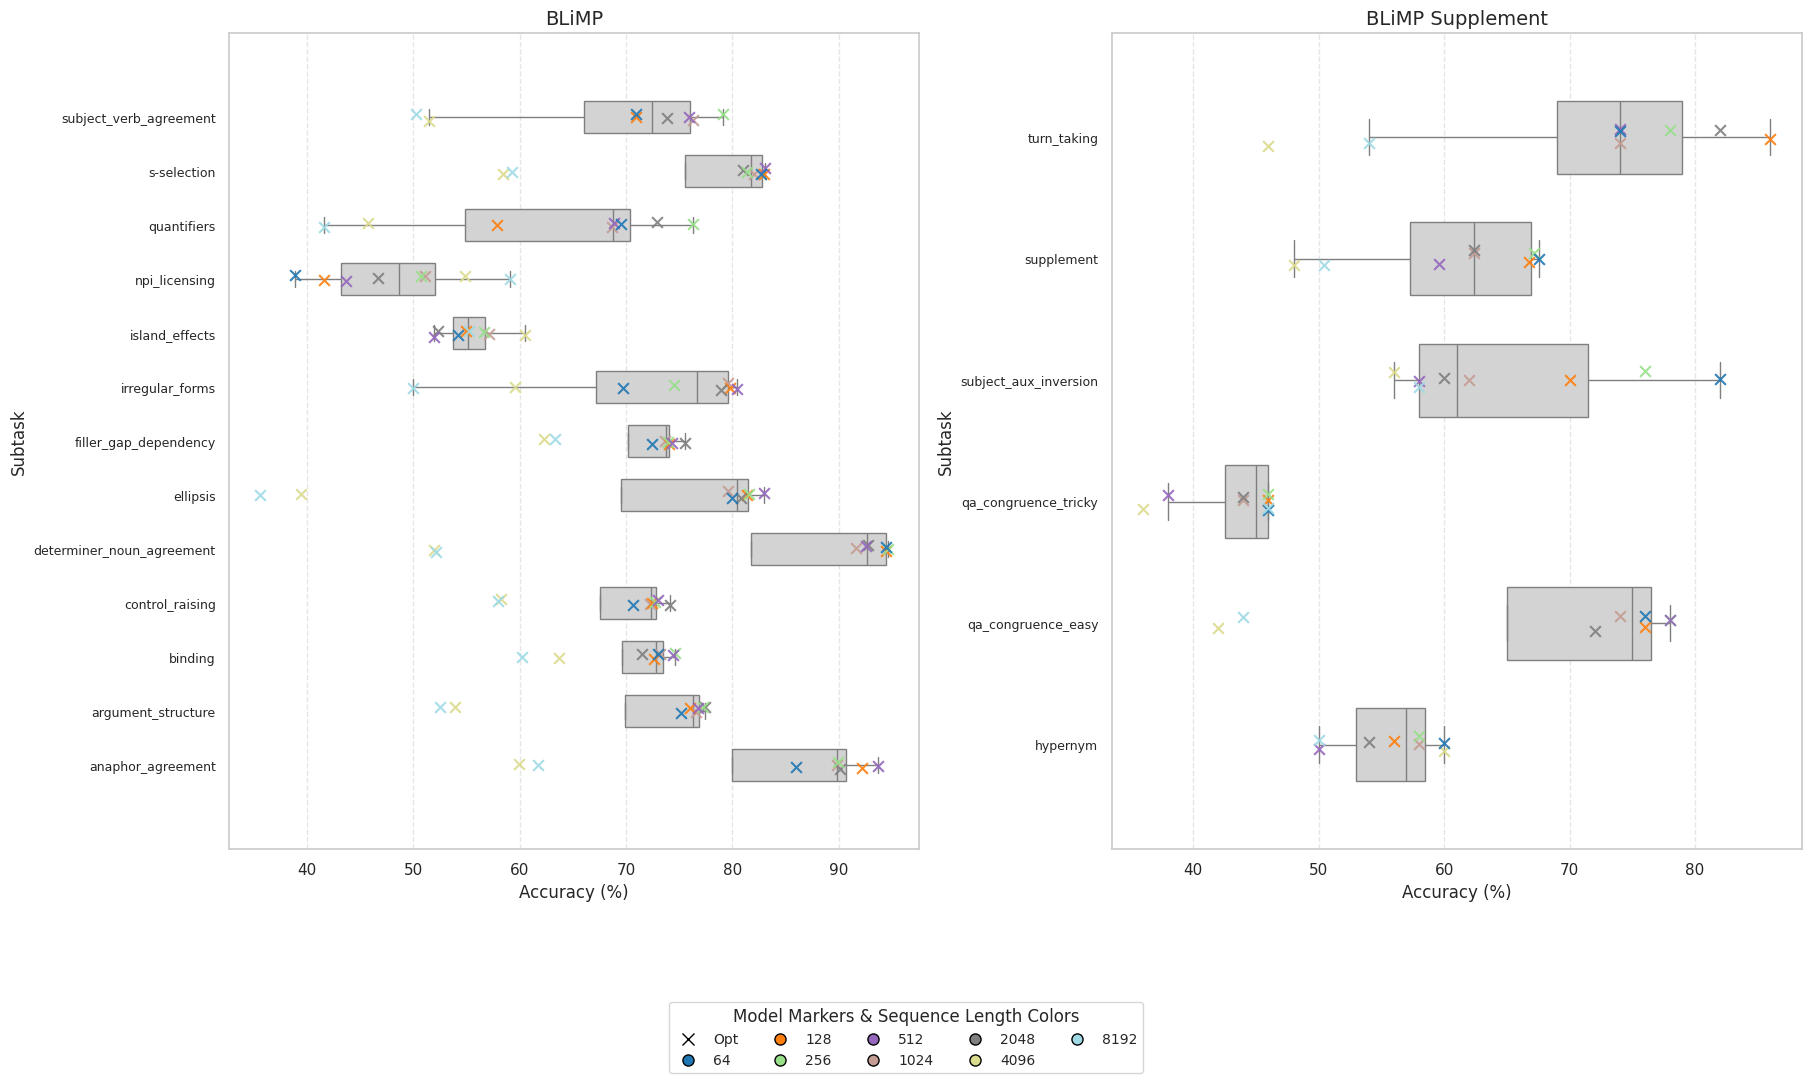

/tmp/ipython-input-3485412668.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-3485412668.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-3485412668.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipython-input-3485412668.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2)  # <-- Make space for legend below figure


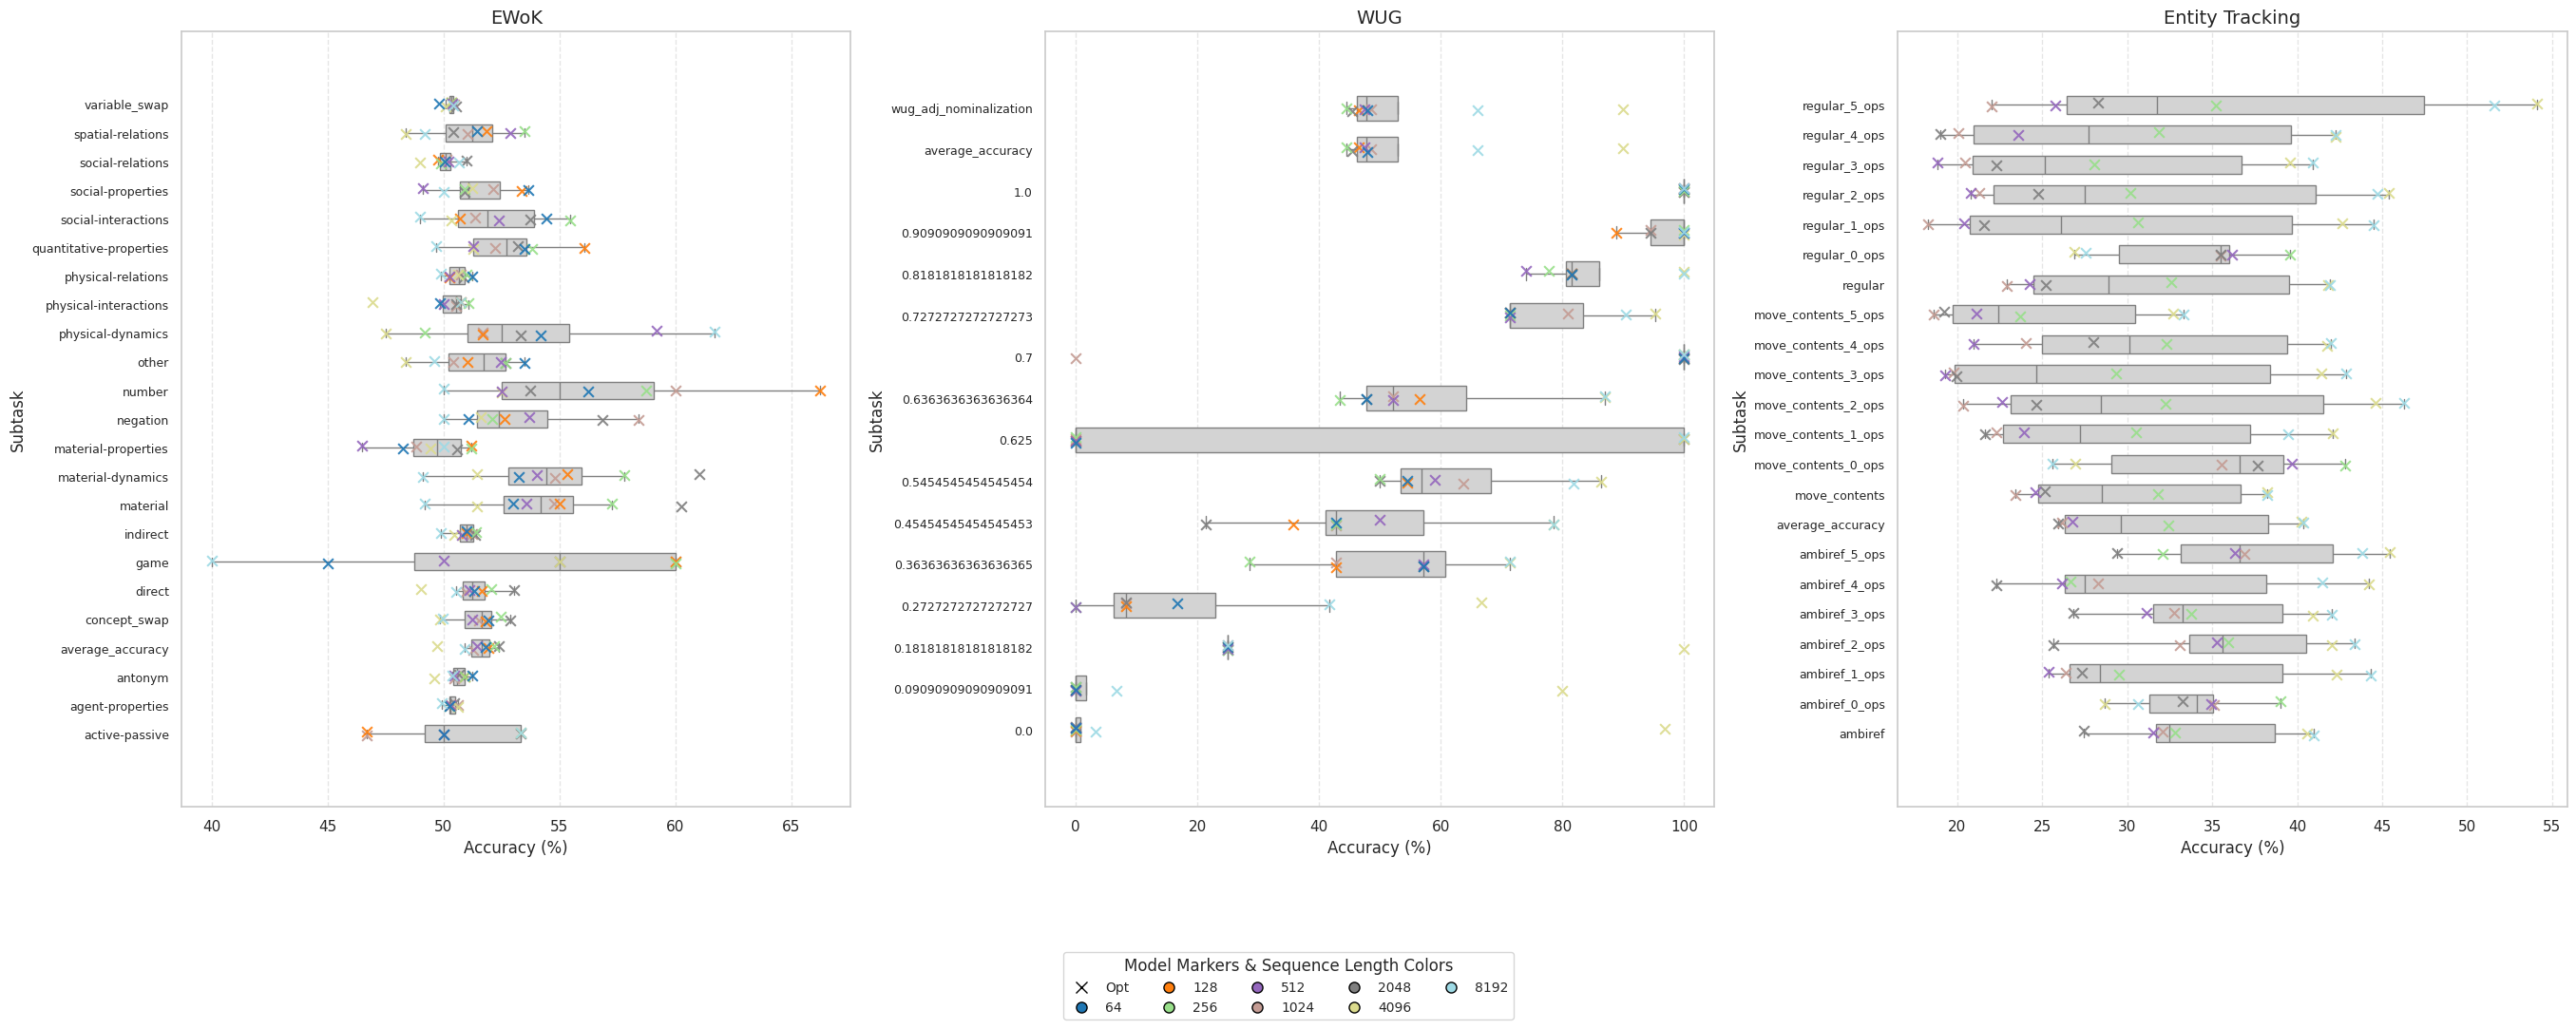

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

def plot_task_panels(df, tasks, axes, pretty_task_names, seq_len_to_color, model_to_marker):
    for ax, task_name in zip(axes, tasks):
        df_task = df[df["task"] == task_name]
        if df_task.empty:
            ax.set_visible(False)
            continue

        subtasks_order = sorted(df_task["subtask"].unique())
        # Boxplot with fixed order, orient horizontal
        sns.boxplot(
            data=df_task,
            y="subtask",
            x="score",
            order=subtasks_order,
            whis=1.5,
            width=0.6,
            fliersize=0,
            color='lightgray',
            orient='h',
            ax=ax
        )

        # Scatter points with jitter around y-position
        for _, row in df_task.iterrows():
            y_pos = subtasks_order.index(row["subtask"])
            jitter = (np.random.rand() - 0.5) * 0.15  # smaller jitter
            ax.scatter(
                row["score"],
                y_pos + jitter,
                marker=model_to_marker.get(row["model"], "o"),
                color=seq_len_to_color.get(row["seq_len"], "gray"),
                edgecolor="black",
                s=60,
                alpha=0.9,
                zorder=3
            )

        ax.set_title(pretty_task_names.get(task_name, task_name), fontsize=14)
        ax.set_xlabel("Accuracy (%)", fontsize=12)
        ax.set_ylabel("Subtask", fontsize=12)
        ax.invert_yaxis()  # to have top subtask at the top

        # Make sure yticks correspond exactly to subtasks with readable font size
        ax.set_yticks(range(len(subtasks_order)))
        ax.set_yticklabels(subtasks_order, fontsize=9)

        # Increase left margin for labels to not cut off text
        ax.margins(y=0.1)
        ax.grid(True, axis='x', linestyle='--', alpha=0.5)

def create_legend(fig, model_to_marker, seq_len_to_color, legend_title, loc='upper center', ncol=5):
    model_handles = [
        Line2D([0], [0], marker=marker, color='w', label=model,
               markerfacecolor='gray', markeredgecolor='black', markersize=8)
        for model, marker in model_to_marker.items()
    ]
    seq_len_handles = [
        Line2D([0], [0], marker='o', color='w', label=str(seq_len),
               markerfacecolor=color, markeredgecolor='black', markersize=8)
        for seq_len, color in seq_len_to_color.items()
    ]
    legend = fig.legend(
        handles=model_handles + seq_len_handles,
        title=legend_title,
        bbox_to_anchor=(0.5, -0.1),  # below figure center
        loc=loc,
        ncol=ncol,
        frameon=True,
        fontsize=10,
        title_fontsize=12
    )
    return legend

# --------
# FIGURE 1: BLiMP and BLiMP Supplement
# --------
fig, axes = plt.subplots(1, 2, figsize=(18, 9), constrained_layout=True)

figure1_tasks = ["zero_shot_causal_blimp", "zero_shot_causal_blimp_supplement_fast"]
plot_task_panels(df, figure1_tasks, axes, pretty_task_names, seq_len_to_color, model_to_marker)
create_legend(fig, model_to_marker, seq_len_to_color, "Model Markers & Sequence Length Colors")

fig.subplots_adjust(bottom=0.2)  # <-- Make space for legend below figure

plt.savefig("figure1_blimp_and_supplement.png", dpi=300)
plt.show()


# --------
# FIGURE 2: EWoK, WUG, Entity Tracking
# --------
fig, axes = plt.subplots(1, 3, figsize=(27, 9), constrained_layout=True)

figure2_tasks = ["zero_shot_causal_ewok", "zero_shot_causal_wug", "zero_shot_causal_entity_tracking"]
plot_task_panels(df, figure2_tasks, axes, pretty_task_names, seq_len_to_color, model_to_marker)
create_legend(fig, model_to_marker, seq_len_to_color, "Model Markers & Sequence Length Colors")

fig.subplots_adjust(bottom=0.2)  # <-- Make space for legend below figure

plt.savefig("figure2_ewok_wug_entity_tracking.png", dpi=300)
plt.show()
